#  Quantum Fourier Transform
##  This notebook can probably be divided into the following sections:
## 1. Quantum Fourier Transfom - different circuits and functions related to setting up the QFT
## 2. Inverse QFT and Setting a Fourier state
## 3.The application of the QFT to a photograph
## 4. A look at the QFT in isolation - code to run checks on performance across different numbers of qubits.
## 5. Test on QFT on its own for different numbers of qubits

# <font color=red> **Important Information for running on the IBM machines** </font>
### In order to keep personal / secure information separate from the Python program, rather than hard-code the quantum server key directly into the Python code, it is stored in the local file called *ibm_token.txt* supplied with this notebook. This file should be placed in the same directory as the notebook, and the code will run against the quantum server.
### <font color=red> **My IBM key is in the file supplied with this notebook - make sure that this is in place before running** </font>

In [52]:
# -*- coding: utf-8 -*-

# This code is part of Qiskit.
#
# (C) Copyright IBM 2017.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""
Quantum Fourier Transform examples.
"""
import numpy as np
import math
from qiskit import QuantumCircuit, execute, QuantumRegister, ClassicalRegister
from qiskit import execute, BasicAer, Aer, IBMQ 
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from PIL import Image
import os
import sys
import random
import math
import cmath
pi = math.pi
pi2 = cmath.pi * 2.0
import time
import csv
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# import basic plot tools
from qiskit.visualization import plot_histogram

# The Construction of the Quantum Fourier Transform

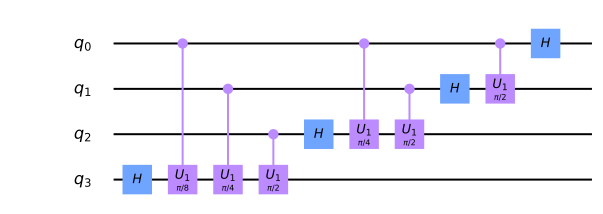

In [29]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cu1(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

# Check how it looks:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw('mpl')

In [30]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit



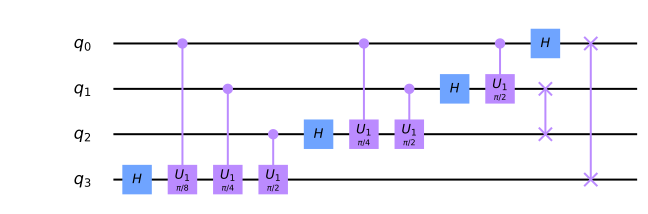

In [31]:
# Checkhow it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw('mpl')

## The Inverse QFT and Setting a Fourier State

In [32]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

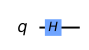

In [33]:
qc = QuantumCircuit(1)
qft_rotations(qc,1)
qc.draw('mpl', scale=0.4)

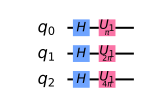

In [34]:
nqubits = 3
number = 4
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.u1(number*pi/4,0)
qc.u1(number*pi/2,1)
qc.u1(number*pi,2)

qc.draw('mpl', scale=0.4)

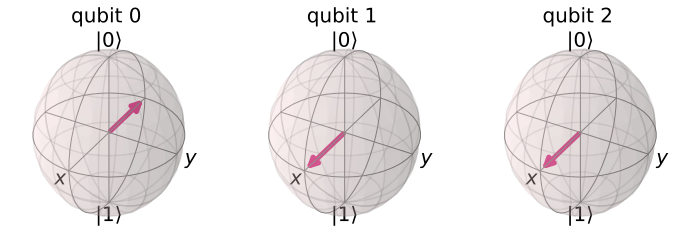

In [35]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

In [36]:
pybinary = bin(5)
binary = pybinary[2:]
print(binary)
print(len(binary))

101
3


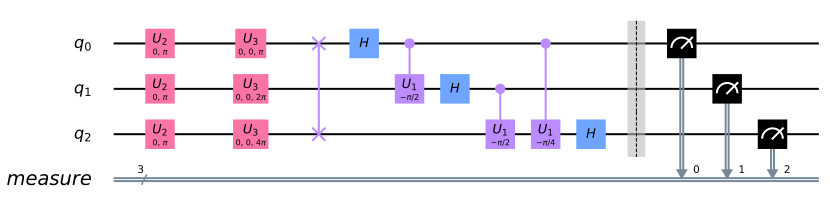

In [37]:

qc = inverse_qft(qc,nqubits)
qc.measure_all()
qc.draw('mpl')

In [13]:
f = open('ibm_token.txt')

ibm_key = f.readline()
f.close()
IBMQ.save_account(ibm_key )

IBMQ.load_account()
IBMQ.providers()

provider = IBMQ.get_provider("ibm-q")




Credentials already present. Set overwrite=True to overwrite.


In [7]:
for backend in provider.backends():
    try:
        qubit_count = len(backend.properties().qubits)
    except:
        qubit_count = "simulated"
        
    print(f"{backend.name()} has {backend.status().pending_jobs} queued and {qubit_count} qubits")

ibmq_qasm_simulator has 4 queued and simulated qubits
ibmqx2 has 9 queued and 5 qubits
ibmq_16_melbourne has 5 queued and 15 qubits
ibmq_vigo has 3 queued and 5 qubits
ibmq_ourense has 5 queued and 5 qubits
ibmq_london has 4 queued and 5 qubits
ibmq_burlington has 3 queued and 5 qubits
ibmq_essex has 4 queued and 5 qubits
ibmq_armonk has 2 queued and 1 qubits
ibmq_rome has 5 queued and 5 qubits


In [15]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)



least busy backend:  ibmqx2


In [16]:
selected_ibm_server = "ibmq_qasm_simulator"
shots =8192
  #backend = provider.get_backend("ibmq_london")
backend = provider.get_backend(selected_ibm_server)

optimization = 3
job = execute(qc, backend=backend, shots=shots, optimization_level=optimization)
job_monitor(job)

Job Status: job has successfully run


In [17]:
counts = job.result().get_counts()
print(counts)

print(int(next(iter(counts)),2))
print(max(counts, key=lambda key: counts[key]))
print(next(iter(counts)))


{'100': 8192}
4
100
100


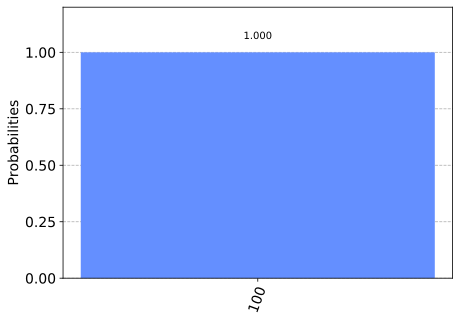

In [18]:
plot_histogram(counts)

In [170]:
print('Qasm simulator')
sim_backend = BasicAer.get_backend('qasm_simulator')
#job = execute([qft3, qft4, qft5], sim_backend, shots=1024)
#result = job.result()
job = execute(qc, backend=sim_backend, shots=shots)
job_monitor(job)

Qasm simulator
Job Status: job has successfully run


In [152]:
# Run on quantum machine

from qiskit import IBMQ

  # Get login token for machines
f = open('ibm_token.txt')

ibm_key = f.readline()
f.close()
IBMQ.save_account(ibm_key )

IBMQ.load_account()
IBMQ.providers()

provider = IBMQ.get_provider("ibm-q")


Credentials already present. Set overwrite=True to overwrite.
Credentials are already in use. The existing account in the session will be replaced.


In [425]:
# Documentation code showing the available servers and state

for backend in provider.backends():
    try:
        qubit_count = len(backend.properties().qubits)
    except:
        qubit_count = "simulated"
        
    print(f"{backend.name()} has {backend.status().pending_jobs} queued and {qubit_count} qubits")

ibmq_qasm_simulator has 3 queued and simulated qubits
ibmqx2 has 3 queued and 5 qubits
ibmq_16_melbourne has 3 queued and 15 qubits
ibmq_vigo has 3 queued and 5 qubits
ibmq_ourense has 5 queued and 5 qubits
ibmq_london has 6 queued and 5 qubits
ibmq_burlington has 3 queued and 5 qubits
ibmq_essex has 3 queued and 5 qubits
ibmq_armonk has 6 queued and 1 qubits
ibmq_rome has 3 queued and 5 qubits


In [213]:
selected_ibm_server = "ibmq_16_melbourne"
shots =8192
#backend = provider.get_backend("ibmq_london")
backend = provider.get_backend(selected_ibm_server)

optimization = 3

from qiskit.tools.monitor import job_monitor
##timeBefore_aer = time.clock()

job = execute([qft3, qft3_koch, qpe, qpe2, qpe3, qft4, qft5,],  backend=backend, shots=8192, max_credits=10,optimization_level=optimization)
##timeAfter_aer = time.clock()

job_monitor(job, interval = 2)

results = job.result()

#answer = results.get_counts(qc)
#plot_histogram(answer)


Job Status: job has successfully run


# Photo data

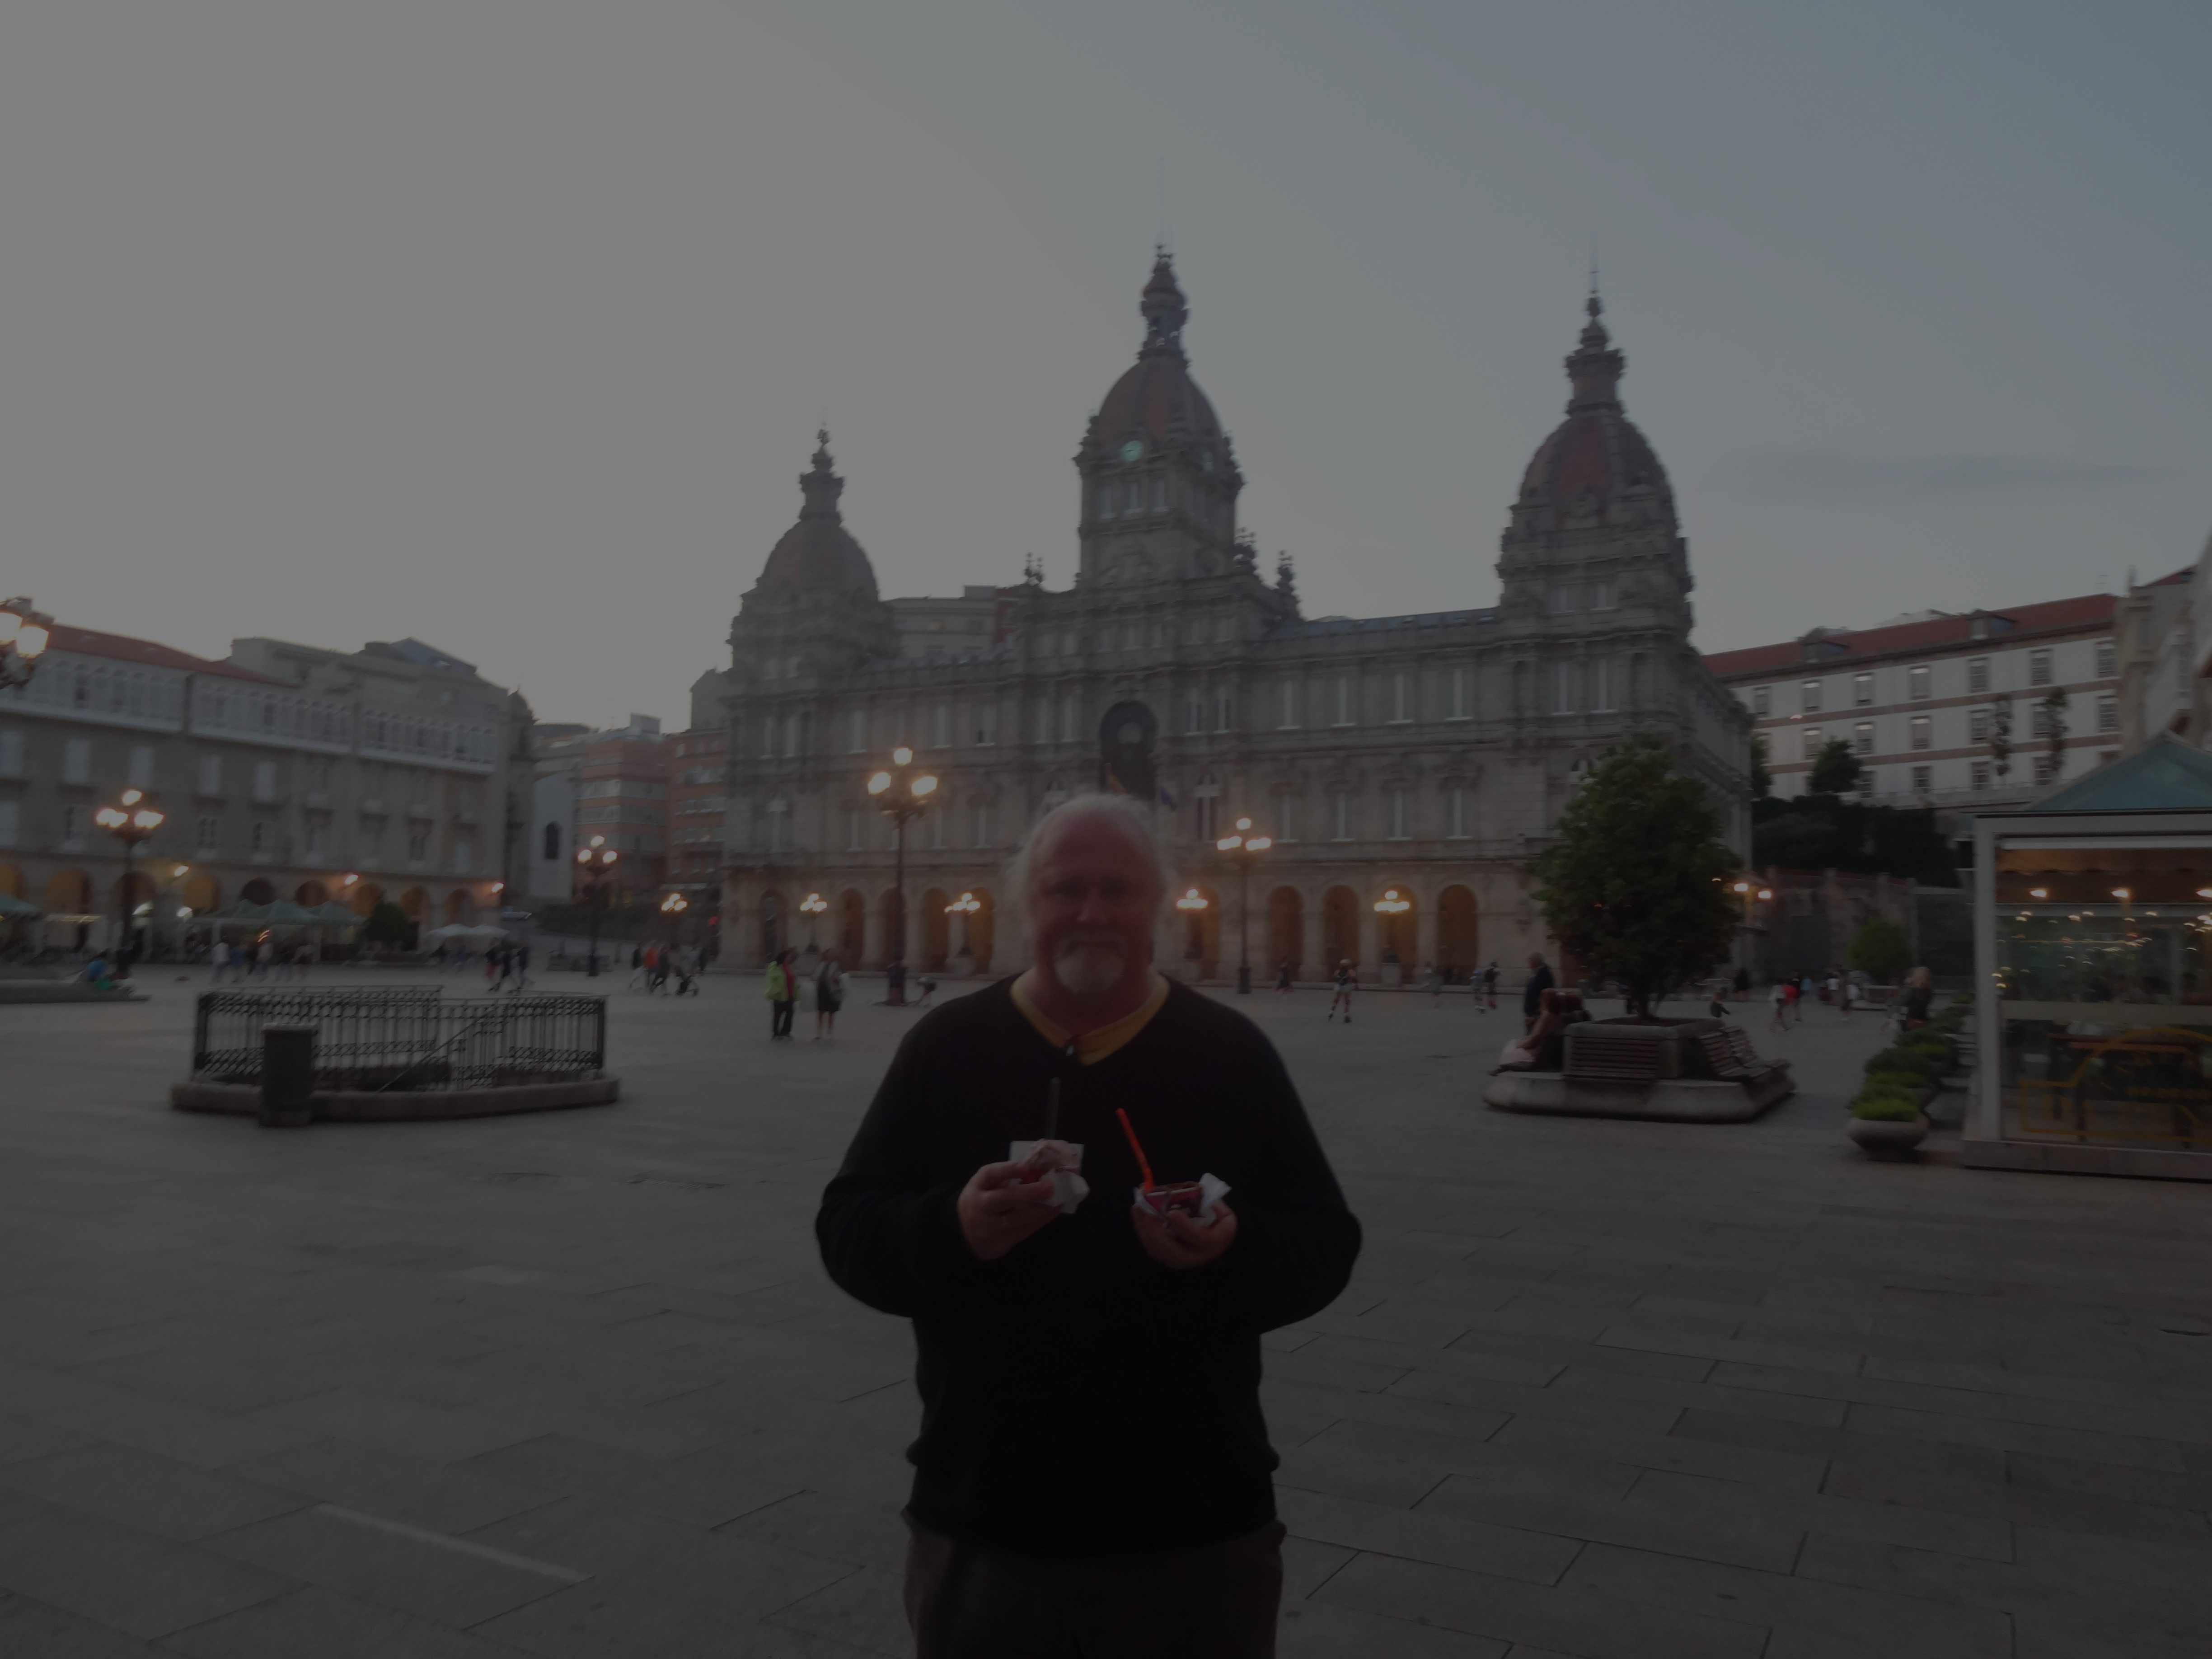

In [56]:
img = Image.open('TomInSquare.jpg')##.convert('RGBA') #open as original colour
arr = np.array(img)
display(img)

In [57]:
shape = arr.shape
print(shape)

(3672, 4896, 3)


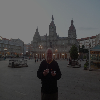

In [58]:
#Array doesn't show (or takes a very long time, so reduce)
small=img.resize([100,100],resample=0)
display(small)

In [59]:
arr = np.array(small)
shape = arr.shape
print(shape)
print(arr)

(100, 100, 3)
[[[127 127 127]
  [127 127 127]
  [127 127 127]
  ...
  [ 99 112 121]
  [ 97 111 122]
  [ 97 109 121]]

 [[127 127 127]
  [127 127 127]
  [127 127 127]
  ...
  [ 99 112 121]
  [ 99 112 121]
  [ 99 111 123]]

 [[127 127 127]
  [127 127 127]
  [127 127 127]
  ...
  [100 115 122]
  [100 113 121]
  [100 113 122]]

 ...

 [[ 51  51  49]
  [ 53  53  51]
  [ 52  52  50]
  ...
  [ 42  41  39]
  [ 42  42  42]
  [ 45  43  44]]

 [[ 53  53  53]
  [ 52  52  52]
  [ 50  50  48]
  ...
  [ 49  47  48]
  [ 38  38  38]
  [ 42  40  41]]

 [[ 51  51  51]
  [ 52  52  52]
  [ 53  53  53]
  ...
  [ 44  44  44]
  [ 44  42  43]
  [ 44  44  44]]]


In [40]:
#Function to set a Fourier state
def set_fourier(qb,n):
    nqubits = qb
    number = n
    print('Hello',n,nqubits)
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    if nqubits >= 1:
        qc.u1(number*pi/4,0)
    if nqubits >= 2:
        qc.u1(number*pi/2,1)
    if nqubits >= 3:
        qc.u1(number*pi,2)
    qc.draw('mpl')
    print('Draw')
    return(qc)
        #qc.draw('mpl', scale=0.4)
    


In [41]:
# Function to send to IBM machine in a loop
def submit_ibm(qc,device):
    selected_ibm_server = device
    shots = 1000
    #print(number)
    #print(qc)
    
    #backend = provider.get_backend("ibmq_london")
    backend = provider.get_backend(selected_ibm_server)

    optimization = 3
    if device != 'ibmq_qasm_simulator':
        job = execute(qc, backend=backend, shots=shots, optimization_level=optimization)
    else:
        job = execute(qc, backend=sim_backend, shots=shots)
    job_monitor(job)

    

In [42]:
### First time in session
IBMQ.save_account(ibm_key )

IBMQ.load_account()
IBMQ.providers()

provider = IBMQ.get_provider("ibm-q")

Credentials already present. Set overwrite=True to overwrite.
Credentials are already in use. The existing account in the session will be replaced.


In [43]:
#Create an array from pullover patch

orig_pullover =  [[ 5, 5, 5], [ 5, 5, 5], [ 5, 5, 7], [ 4, 4, 4], [ 4, 4, 6], [ 6, 6, 6], [ 3, 3, 3], [ 4, 4, 4], [ 5, 5, 5], [ 4, 4, 6], [ 4, 4, 4], [ 6, 6, 6]]
#orig_pullover =  [[ 5, 3, 5]]
pullover=[j for sub in orig_pullover for j in sub] #Flatten to make things easier

fourier_pullover = []
matches = []
count_list = []
print(pullover)
#print(len(pullover))

[5, 5, 5, 5, 5, 5, 5, 5, 7, 4, 4, 4, 4, 4, 6, 6, 6, 6, 3, 3, 3, 4, 4, 4, 5, 5, 5, 4, 4, 6, 4, 4, 4, 6, 6, 6]


## The code below runs in a loop. 
## It works through the data and submits the appropriate circuits (based on the required number of qubits)  to the IBM servers repeatedly.

In [ ]:
    # Set Fourier State for the pixels
    # Then do Inverse Fourier on Quantum Machine
#nqubits = 1
#qc=QuantumCircuit(nqubits)
now = str(int(time.time())) +'.csv'
result_file = 'results_'+ now

device = 'ibmq_burlington'

for k in range(5):
     print('Run: ',k)
     for i in tqdm(range(len(pullover))):
        #print(j)
        pybinary = bin(pullover[i])
        binary = pybinary[2:]
        nqubits = len(binary)
        number = pullover[i]
        #qc=set_fourier(num_qubits,pullover[i])
        
        
        #set_fourier(num_qubits,number)
        
        
        qc = QuantumCircuit(nqubits)
        for qubit in range(nqubits):
            qc.h(qubit)
        if nqubits >= 1:
            qc.u1(number*pi/4,0)
        if nqubits >= 2:
            qc.u1(number*pi/2,1)
        if nqubits >= 3:
            qc.u1(number*pi,2)
        
        #qc.draw('mpl')
        qc = inverse_qft(qc,nqubits)
        qc.measure_all()
        #qc.draw('mpl')

        
        selected_ibm_server = device
        shots =1000
        #print(number)
        #print(qc)
    
        #backend = provider.get_backend("ibmq_london")
        backend = provider.get_backend(selected_ibm_server)

        optimization = 3
        if device != 'ibmq_qasm_simulator':
            job = execute(qc, backend=backend, shots=shots, optimization_level=optimization)
        else:
            job = execute(qc, backend=sim_backend, shots=shots)
        job_monitor(job)

   

        ###submit_ibm(qc,"ibmq_qasm_simulator")
        counts = job.result().get_counts()
        print(counts)
        #fourier_pullover.append(int(next(iter(counts)),2))
        
        #Write Results to File
        fourier_pullover.append(int(max(counts, key=lambda key: counts[key]) ,2))
        #count_list=[]
        count_list.append(counts)
        
#         for key in counts:
#             value = counts[key]
#             count_out=[key,value]
#             count_list.append(count_out)
#             #count_list.append(value)
#             #print(key, ",", value)
#             #print(test)
        
        #result_file
     with open(result_file, 'a', newline='') as quant_csvfile:
            with open(result_file, 'a', newline='') as csvfile:
                result_write = csv.writer(csvfile)
                for j in range(len(pullover)):
                    #res = pullover[j],fourier_pullover[j]
                    res1 = pullover[j]
                    res2 = fourier_pullover[j]
                    res3 = count_list[j]
                    result_write.writerow([res1,res2, res3])
#                    count_row=[]
#                    
#                     for k in range(len(count_list)):
#                         count_row.append(count_list[k][0])
#                         count_row.append(count_list[k][1])


                    #count_list=[]
print('Process Finished')

Run:  0


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

Job Status: job has successfully run
{'011': 42, '100': 77, '110': 35, '111': 84, '101': 486, '010': 12, '001': 210, '000': 54}


  3%|██▎                                                                                | 1/36 [01:12<42:18, 72.54s/it]

Job Status: job has successfully run
{'011': 37, '100': 33, '110': 37, '111': 54, '101': 151, '010': 60, '001': 495, '000': 133}


  6%|████▍                                                                           | 2/36 [04:32<1:02:44, 110.73s/it]

Job Status: job has successfully run
{'011': 37, '100': 79, '110': 27, '111': 96, '101': 510, '010': 13, '001': 173, '000': 65}


  8%|██████▋                                                                         | 3/36 [07:53<1:15:46, 137.77s/it]

Job Status: job has successfully run
{'011': 35, '100': 79, '110': 24, '111': 103, '101': 490, '010': 15, '001': 197, '000': 57}


 11%|████████▉                                                                       | 4/36 [08:58<1:01:55, 116.10s/it]

Job Status: job has successfully run
{'011': 39, '100': 79, '110': 23, '111': 88, '101': 493, '010': 9, '001': 211, '000': 58}


 14%|███████████                                                                     | 5/36 [12:16<1:12:34, 140.46s/it]

Job Status: job has successfully run
{'011': 43, '100': 91, '110': 77, '111': 103, '101': 372, '010': 29, '001': 181, '000': 104}


 17%|█████████████▎                                                                  | 6/36 [15:42<1:20:03, 160.11s/it]

Job Status: job has successfully run
{'011': 31, '100': 67, '110': 24, '111': 107, '101': 515, '010': 10, '001': 198, '000': 48}


 19%|███████████████▌                                                                | 7/36 [19:06<1:23:46, 173.34s/it]

Job Status: job has successfully run
{'011': 38, '100': 92, '110': 74, '111': 93, '101': 392, '010': 42, '001': 166, '000': 103}


 22%|█████████████████▊                                                              | 8/36 [22:25<1:24:28, 181.03s/it]

Job Status: job has successfully run
{'011': 182, '100': 16, '110': 64, '111': 457, '101': 67, '010': 50, '001': 122, '000': 42}


 25%|████████████████████▌                                                             | 9/36 [22:44<59:38, 132.55s/it]

Job Status: job has successfully run
{'011': 13, '100': 578, '110': 105, '111': 11, '101': 30, '010': 45, '001': 18, '000': 200}


 28%|█████████████████████▉                                                         | 10/36 [26:04<1:06:14, 152.86s/it]

Job Status: job has successfully run
{'011': 11, '100': 574, '110': 108, '111': 17, '101': 27, '010': 46, '001': 16, '000': 201}


 31%|████████████████████████▊                                                        | 11/36 [26:27<47:20, 113.63s/it]

Job Status: job has successfully run
{'011': 12, '100': 581, '110': 110, '111': 10, '101': 32, '010': 40, '001': 14, '000': 201}


 33%|███████████████████████████                                                      | 12/36 [29:42<55:14, 138.10s/it]

Job Status: job has successfully run
{'011': 14, '100': 476, '110': 96, '111': 39, '101': 114, '010': 42, '001': 20, '000': 199}


 36%|████████████████████████████▌                                                  | 13/36 [33:33<1:03:39, 166.08s/it]

Job Status: job has successfully run
{'011': 23, '100': 181, '110': 39, '111': 46, '101': 62, '010': 45, '001': 59, '000': 545}


 39%|██████████████████████████████▋                                                | 14/36 [36:53<1:04:33, 176.09s/it]

Job Status: job has successfully run
{'011': 76, '100': 44, '110': 114, '111': 72, '101': 46, '010': 454, '001': 64, '000': 130}


 42%|████████████████████████████████▉                                              | 15/36 [40:39<1:06:54, 191.15s/it]

Job Status: job has successfully run
{'011': 17, '100': 78, '110': 536, '111': 20, '101': 8, '010': 206, '001': 16, '000': 119}


 44%|███████████████████████████████████                                            | 16/36 [43:57<1:04:26, 193.32s/it]

Job Status: job has successfully run
{'011': 64, '100': 31, '110': 109, '111': 58, '101': 22, '010': 502, '001': 56, '000': 158}


 47%|█████████████████████████████████████▎                                         | 17/36 [47:19<1:02:02, 195.93s/it]

Job Status: job has successfully run
{'011': 50, '100': 120, '110': 280, '111': 94, '101': 50, '010': 198, '001': 61, '000': 147}


 50%|████████████████████████████████████████▌                                        | 18/36 [50:43<59:28, 198.27s/it]

Job Status: job has successfully run
{'10': 362, '11': 69, '01': 382, '00': 187}


 53%|██████████████████████████████████████████▊                                      | 19/36 [54:46<59:57, 211.64s/it]

Job Status: job has successfully run
{'10': 368, '11': 54, '01': 403, '00': 175}


 56%|█████████████████████████████████████████████                                    | 20/36 [58:05<55:25, 207.86s/it]

Job Status: job has successfully run
{'10': 353, '11': 58, '01': 431, '00': 158}


 58%|███████████████████████████████████████████████▎                                 | 21/36 [58:24<37:46, 151.11s/it]

Job Status: job has successfully run
{'011': 27, '100': 454, '110': 101, '111': 34, '101': 118, '010': 28, '001': 33, '000': 205}


 61%|█████████████████████████████████████████████████▌                               | 22/36 [58:43<26:01, 111.54s/it]

Job Status: job has successfully run
{'011': 30, '100': 159, '110': 46, '111': 54, '101': 56, '010': 57, '001': 60, '000': 538}


 64%|████████████████████████████████████████████████████▍                             | 23/36 [59:01<18:07, 83.65s/it]

Job Status: job has successfully run
{'011': 29, '100': 188, '110': 39, '111': 48, '101': 66, '010': 48, '001': 45, '000': 537}


 67%|██████████████████████████████████████████████████████▋                           | 24/36 [59:21<12:52, 64.35s/it]

Job Status: job has successfully run
{'011': 36, '100': 40, '110': 18, '111': 100, '101': 539, '010': 9, '001': 210, '000': 48}


 69%|█████████████████████████████████████████████████████▍                       | 25/36 [1:22:25<1:24:22, 460.27s/it]

Job Status: job has successfully run
{'011': 41, '100': 72, '110': 46, '111': 104, '101': 411, '010': 49, '001': 173, '000': 104}


 72%|███████████████████████████████████████████████████████▌                     | 26/36 [1:40:44<1:48:41, 652.10s/it]

Job Status: job has successfully run
{'011': 50, '100': 49, '110': 19, '111': 95, '101': 489, '010': 13, '001': 241, '000': 44}


 75%|█████████████████████████████████████████████████████████▊                   | 27/36 [1:59:34<1:59:17, 795.28s/it]

Job Status: job has successfully run
{'011': 24, '100': 452, '110': 95, '111': 41, '101': 133, '010': 48, '001': 32, '000': 175}


 78%|███████████████████████████████████████████████████████████▉                 | 28/36 [2:12:09<1:44:25, 783.18s/it]

Job Status: job has successfully run
{'011': 8, '100': 573, '110': 92, '111': 12, '101': 35, '010': 45, '001': 20, '000': 215}


 81%|██████████████████████████████████████████████████████████████               | 29/36 [2:30:28<1:42:26, 878.07s/it]

Job Status: job has successfully run
{'011': 19, '100': 74, '110': 535, '111': 29, '101': 9, '010': 193, '001': 22, '000': 119}


 83%|███████████████████████████████████████████████████████████████▎            | 30/36 [2:55:17<1:46:07, 1061.30s/it]

Job Status: job has successfully run
{'011': 13, '100': 590, '110': 95, '111': 19, '101': 31, '010': 45, '001': 15, '000': 192}


 86%|█████████████████████████████████████████████████████████████████▍          | 31/36 [3:13:50<1:29:43, 1076.69s/it]

Job Status: job has successfully run
{'011': 17, '100': 570, '110': 111, '111': 18, '101': 30, '010': 41, '001': 16, '000': 197}


 89%|███████████████████████████████████████████████████████████████████▌        | 32/36 [3:33:20<1:13:39, 1104.86s/it]

Job Status: job has successfully run
{'011': 17, '100': 542, '110': 108, '111': 13, '101': 33, '010': 47, '001': 22, '000': 218}


 92%|███████████████████████████████████████████████████████████████████████▌      | 33/36 [3:52:18<55:44, 1114.77s/it]

Job Status: job has successfully run
{'011': 55, '100': 106, '110': 331, '111': 97, '101': 35, '010': 206, '001': 42, '000': 128}


 94%|█████████████████████████████████████████████████████████████████████████▋    | 34/36 [4:16:39<40:36, 1218.46s/it]

Job Status: job has successfully run
{'011': 67, '100': 35, '110': 143, '111': 55, '101': 28, '010': 490, '001': 49, '000': 133}


 97%|███████████████████████████████████████████████████████████████████████████▊  | 35/36 [4:34:04<19:26, 1166.43s/it]

Job Status: job has successfully run
{'011': 17, '100': 85, '110': 541, '111': 30, '101': 12, '010': 199, '001': 11, '000': 105}


100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [4:52:10<00:00, 486.95s/it]


Run:  1


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

Job Status: job has successfully run
{'011': 49, '100': 32, '110': 24, '111': 47, '101': 175, '010': 47, '001': 498, '000': 128}


  3%|██▏                                                                           | 1/36 [23:11<13:31:53, 1391.82s/it]

Job Status: job has successfully run
{'011': 44, '100': 60, '110': 30, '111': 106, '101': 515, '010': 19, '001': 196, '000': 30}


  6%|████▎                                                                         | 2/36 [41:39<12:20:27, 1306.69s/it]

# Checking values and testing

In [ ]:
print(fourier_pullover)
print(number)
print(nqubits)
print(counts)
qc.draw('mpl')
print(list(counts.values()))
#test=[]
for key in counts:
    value = counts[key]


    print(key, ",", value)
print(count_list)

In [412]:
counts = job.result().get_counts()
print(counts)
print(number)
print(count_list)
print(count_list[0])
print(len(fourier_pullover))
print(len(count_list))

{'101': 1000}
5
[['101', 1000], ['00', 77], ['10', 414], ['01', 433], ['11', 76], ['101', 1000], [['101', 1000]], [['00', 67]], [['10', 430]], [['01', 424]], [['11', 79]], [['101', 1000]]]
['101', 1000]
6
12
1000


In [ ]:
matches=[]
match_count=0
miss_count = 0


for i in range(len(pullover)):
    if pullover[i]==fourier_pullover[i]:
        matches.append(1)
        match_count +=1
    else:
        matches.append(0)
        miss_count+=1

print(matches)
print(pullover)
print(fourier_pullover)
print('Matches:',match_count)
print('Misses: ', miss_count)


# now = str(int(time.time())) +'.csv'
# result_file = 'results_'+ now

print(pullover)
print(fourier_pullover)

# with open(result_file, 'a', newline='') as quant_csvfile:
#             with open(result_file, 'a', newline='') as csvfile:
#                 result_write = csv.writer(csvfile)
#                 for j in range(len(pullover)):
#                     #res = pullover[j],fourier_pullover[j]
#                     res1 = pullover[j]
#                     res2 = fourier_pullover[j]
#                     result_write.writerow([res1,res2])

# Test QFT on its own - |0> Test

This code is adapted from https://github.com/christianb93/QuantumComputing

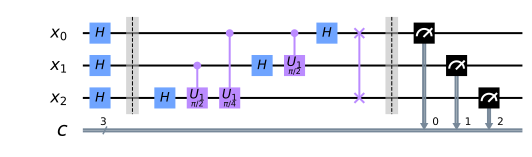

In [25]:
def nBitQFT(q,c,n=3):
    circuit = QuantumCircuit(q,c)
    #
    # We start with the most significant bit
    #
    for k in range(n):
        j = n - k
        # Add the Hadamard to qubit j-1
        circuit.h(q[j-1])
        #
        # there is one conditional rotation for
        # each qubit with lower significance
        for i in reversed(range(j-1)):
            circuit.cu1(2*np.pi/2**(j-i),q[i], q[j-1])
    #
    # Finally we need to swap qubits
    #
    for i in range(n//2):
        circuit.swap(q[i], q[n-i-1])
    return circuit

n=3
q = QuantumRegister(n,"x")
c = ClassicalRegister(n,"c")
qftCircuit = nBitQFT(q,c,n)
initCircuit = QuantumCircuit(q,c)
for i in range(n):
    initCircuit.h(q[i])
initCircuit.barrier(q)
circuit = initCircuit + qftCircuit
circuit.barrier(q)
circuit.measure(q,c)
#drawer(circuit, style=my_style)
circuit.draw('mpl', scale=0.5)

In [26]:
from qiskit.tools.monitor import job_monitor
#for i in range(0.5)
selected_ibm_server = "ibmq_rome"
shots =1000
#backend = provider.get_backend("ibmq_london")
backend = provider.get_backend(selected_ibm_server)

optimization = 3


##timeBefore_aer = time.clock()

job = execute(circuit, backend=backend, shots=shots)

#job = backend.run(qobj)
job_monitor(job, interval = 2)

results = job.result()

#answer = results.get_counts(qc)

Job Status: job has successfully run


In [27]:
job.result().get_counts()

{'100': 123,
 '101': 11,
 '110': 39,
 '011': 9,
 '010': 46,
 '000': 743,
 '111': 9,
 '001': 20}

## Misc. Test Stuff

Job Status: job has successfully run


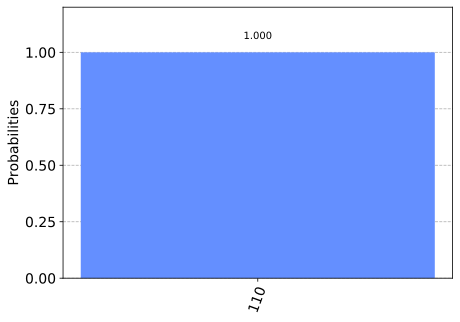

In [270]:
#Test
submit_ibm(qc,"ibmq_qasm_simulator")

results = job.result()

answer = results.get_counts(qc)
#plot_histogram(answer)


counts = job.result().get_counts()
plot_histogram(counts)


In [278]:
answer = results.get_counts(qc)
print(answer)
int(next(iter(counts)),2)

{'110': 8192}


6